In [4]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath("../.."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from src.utils import *
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [9]:
# Load data (just after splitting)
train_images = np.load("/Users/inescunha/Documents/GitHub/CellFate/data/images/train_images.npy")
test_images = np.load("/Users/inescunha/Documents/GitHub/CellFate/data/images/test_images.npy")
train_labels = np.load("/Users/inescunha/Documents/GitHub/CellFate/data/labels/train_labels.npy")
test_labels = np.load("/Users/inescunha/Documents/GitHub/CellFate/data/labels/test_labels.npy")
train_tracks = np.load("/Users/inescunha/Documents/GitHub/CellFate/data/tracks/train_tracks.npy")
test_tracks = np.load("/Users/inescunha/Documents/GitHub/CellFate/data/tracks/test_tracks.npy")

# Load full data

x_train_full = np.load('../data/images/time_norm_train_images.npy')[:,0,:,:]

In [ ]:
for i in range(1,11):
    print(int(i * 0.1 * len(train_labels)))

110
221
332
443
554
664
775
886
997
1108


In [3]:
dataset_size = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

def data_size_study(dataset_size, train_images, train_labels, train_tracks, test_images, test_labels, test_tracks, x_train_full, seed=42):

    np.random.seed(seed)
    confusion_matrices_cellfate = np.zeros((len(dataset_size), 2, 2))

    for size in dataset_size:
        
        # Create new output directory folder with the size 
        output_dir=f"../results/data_labelling_study/seed{seed}_split_{size}"
        os.makedirs(output_dir, exist_ok=True)

        less_indexes = np.random.choice(np.arange(len(train_labels)), int(size * len(train_labels)), replace=False)

        # Get less training data
        smaller_x_train_images = train_images[np.sort(less_indexes)]
        smaller_y_train = train_labels[np.sort(less_indexes)]

        # Augment image data
        smaller_train_images_augmented, smaller_train_labels_augmented = augment_dataset(smaller_x_train_images, smaller_y_train, augmentations)

        # Stretch intensities of new images (train and test)
        stretched_x_train_smaller, stretched_x_test = stretch_intensities_global(smaller_train_images_augmented, test_images)

        # Pick only frame zero
        x_train = stretched_x_train_smaller[:,0,:,:]
        y_train = smaller_train_labels_augmented
        x_test = stretched_x_test[:,0,:,:]
        y_test = test_labels

        print("X_train size: ", x_train.shape, "Y_train size: ", y_train.shape, "X_test size: ", x_test.shape, "Y_test size: ", y_test.shape)

        # IMAGES: Train autoencoder only
        
        config_ae = {
            'batch_size': 30,
            'epochs': 15,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 5,
            'lambda_adv': 1,
        }

        config_cellfate = {
            'batch_size': 30,
            'epochs': 100,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 6,
            'lambda_adv': 4,
            'lambda_cov': 0.0001,
            'lambda_contra': 8,
        }

        config_clf = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
        }

        results_autoencoder = train_autoencoder(config_ae, x_train_full)
        encoder = results_autoencoder['encoder']
        decoder = results_autoencoder['decoder']
        discriminator = results_autoencoder['discriminator']

        # IMAGES: Train AIcellfate with smaller dataset

        results_cellfate = train_cellfate(config_cellfate, encoder, decoder, discriminator, x_train, y_train, x_test, y_test) #lambda_recon=scaled_autoencoder_results['lambda_recon'], lambda_adv=scaled_autoencoder_results['lambda_adv']
        encoder = results_cellfate['encoder']
        decoder = results_cellfate['decoder']
        discriminator = results_cellfate['discriminator']

        save_model_weights_to_disk(encoder, decoder, discriminator, output_dir=output_dir)
        
        evaluator = Evaluation(output_dir)

        # Evaluate the model (and saving everything)
        z_imgs = encoder.predict(x_train)
        recon_imgs = decoder.predict(z_imgs)
        evaluator.reconstruction_images(x_train, recon_imgs[:,:,:,0], epoch=0)
        evaluator.visualize_latent_space(z_imgs, y_train, epoch=0)
       
        tf.keras.utils.set_random_seed(config_clf['seed'])

        classifier = mlp_classifier(latent_dim=config_clf['latent_dim'])
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_clf['learning_rate']), metrics=['accuracy'])

        x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) 
        history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config_clf['batch_size'], epochs=config_clf['epochs'], validation_data=(x_val, y_val)) 

        y_pred = classifier.predict(x_test_)
        y_pred_classes = np.argmax(y_pred, axis=1)
        num_classes = len(np.unique(y_test_))

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums
        
        confusion_matrices_cellfate[dataset_size.index(size)] = conf_matrix_normalized

        # Save confusion matrix
        plot_confusion_matrix(y_test_, y_pred, num_classes)
        np.save(f"{output_dir}/confusion_matrices_cellfate.npy", confusion_matrices_cellfate)

    return confusion_matrices_cellfate



X_train size:  (2184, 20, 20) Y_train size:  (2184,) X_test size:  (277, 20, 20) Y_test size:  (277,)
Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 44, latent dim: 2


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.3784, Adversarial loss: 0.7635, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.8037, Adversarial loss: 0.7309, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7664, Adversarial loss: 0.7170, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7403, Adversarial loss: 0.7058, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7372, Adversarial loss: 0.7007, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7407, Adversarial loss: 0.7095, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7188, Adversarial loss: 0.7045, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7354, Adversarial loss: 0.7028, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7330, Adversarial loss: 0.6967, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Training with batch size: 30, epochs: 100, learning rate: 0.001, seed: 44, latent dim: 2
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
kl_divergence[0]: 0.27069763851604267 kl_divergence[1]: 0.8070022590927942
Epoch 1/100: Reconstruction loss: 0.8965, Adversarial loss: 2.8040, Contrastive loss: 5.5803, Covariance loss: 0.0000, lamdba recon: 6.0000, lambda adv: 4.0000, lambda cov: 0.0001, lambda contra: 8.0000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
kl_divergence[0]: 0.13789648903800686 kl_divergence[1]: 2.2211795763178843
Epoch 2/100: Reconstruction loss: 0.9076, Adversarial loss: 2.7987, Contrastive loss: 5.4430, Covariance loss: 0.0000, lamdba recon: 6.0000, lambda adv: 4.0000, lambda cov: 0.0001, lambda contra: 8.0000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
kl_divergence[0]: 0.030502095555072467 kl_divergence[1]: 0.25583828020673866
Epoch 3/100: Reconstruction loss: 1.0246, Adver

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_5 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3807 - loss: 0.8760 - val_accuracy: 0.4130 - val_loss: 0.7623
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.3845 - loss: 0.8087 - val_accuracy: 0.4203 - val_loss: 0.7330
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.4051 - loss: 0.7537 - val_accuracy: 0.4493 - val_loss: 0.7077
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.4287 - loss: 0.7151 - val_accuracy: 0.5145 - val_loss: 0.6894
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.5431 - loss: 0.6910 - val_accuracy: 0.6377 - val_loss: 0.6749
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.5821 - loss: 0.6752 - val_accuracy: 0.6377 - val_loss: 0.6631
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.6110 - loss: 0.6611 - val_accuracy: 0.6522 - val_loss: 0.6530
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.6416 - loss: 0.6507 - val_accuracy: 0.65

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_6 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6374 - loss: 0.6736 - val_accuracy: 0.6812 - val_loss: 0.5997
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6383 - loss: 0.6463 - val_accuracy: 0.6812 - val_loss: 0.5990
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.6288 - loss: 0.6498 - val_accuracy: 0.6812 - val_loss: 0.5977
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6338 - loss: 0.6373 - val_accuracy: 0.6884 - val_loss: 0.5980
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - accuracy: 0.6380 - loss: 0.6379 - val_accuracy: 0.6812 - val_loss: 0.6015
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.6298 - loss: 0.6386 - val_accuracy: 0.6884 - val_loss: 0.6050
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6390 - loss: 0.6325 - val_accuracy: 0.6884 - val_loss: 0.6038
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6568 - loss: 0.6264 - val_accuracy: 0.68

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_7 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4576 - loss: 1.0854 - val_accuracy: 0.4855 - val_loss: 0.9190
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.4691 - loss: 1.0346 - val_accuracy: 0.5507 - val_loss: 0.8685
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.4754 - loss: 0.9672 - val_accuracy: 0.5435 - val_loss: 0.8277
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.4770 - loss: 0.9469 - val_accuracy: 0.5290 - val_loss: 0.7912
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.4882 - loss: 0.9007 - val_accuracy: 0.5652 - val_loss: 0.7648
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.5111 - loss: 0.8596 - val_accuracy: 0.5652 - val_loss: 0.7412
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.5290 - loss: 0.8267 - val_accuracy: 0.5725 - val_loss: 0.7207
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.5315 - loss: 0.7909 - val_accuracy: 0.55

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3729 - loss: 1.2774 - val_accuracy: 0.3116 - val_loss: 1.1852
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.3672 - loss: 1.2274 - val_accuracy: 0.3261 - val_loss: 1.1258
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.3604 - loss: 1.1831 - val_accuracy: 0.3333 - val_loss: 1.0707
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.3825 - loss: 1.1216 - val_accuracy: 0.3478 - val_loss: 1.0171
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.3865 - loss: 1.0595 - val_accuracy: 0.3478 - val_loss: 0.9705
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3663 - loss: 1.0011 - val_accuracy: 0.3768 - val_loss: 0.9300
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.3800 - loss: 0.9795 - val_accuracy: 0.3841 - val_loss: 0.8892
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.4096 - loss: 0.9162 - val_accuracy: 0.39

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_9 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4325 - loss: 1.5108 - val_accuracy: 0.4058 - val_loss: 1.1380
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.4442 - loss: 1.3995 - val_accuracy: 0.4058 - val_loss: 1.0815
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - accuracy: 0.4244 - loss: 1.2940 - val_accuracy: 0.3986 - val_loss: 1.0236
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.4219 - loss: 1.2541 - val_accuracy: 0.4058 - val_loss: 0.9714
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - accuracy: 0.4310 - loss: 1.1433 - val_accuracy: 0.4058 - val_loss: 0.9176
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.4466 - loss: 1.0952 - val_accuracy: 0.4058 - val_loss: 0.8721
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.4357 - loss: 0.9973 - val_accuracy: 0.4058 - val_loss: 0.8277
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.4455 - loss: 0.9388 - val_accuracy: 0.41

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_10 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6454 - loss: 0.6468 - val_accuracy: 0.7246 - val_loss: 0.6388
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.6473 - loss: 0.6280 - val_accuracy: 0.7246 - val_loss: 0.6257
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.6616 - loss: 0.6207 - val_accuracy: 0.7246 - val_loss: 0.6195
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6543 - loss: 0.6185 - val_accuracy: 0.7246 - val_loss: 0.6155
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6353 - loss: 0.6216 - val_accuracy: 0.7246 - val_loss: 0.6114
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.6542 - loss: 0.6149 - val_accuracy: 0.7246 - val_loss: 0.6088
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - accuracy: 0.6410 - loss: 0.6145 - val_accuracy: 0.7246 - val_loss: 0.6070
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.6537 - loss: 0.6135 - val_accuracy: 0.73

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_11 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5941 - loss: 0.8316 - val_accuracy: 0.5580 - val_loss: 0.8182
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.5669 - loss: 0.8271 - val_accuracy: 0.5580 - val_loss: 0.7717
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.5846 - loss: 0.7588 - val_accuracy: 0.5870 - val_loss: 0.7306
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.5820 - loss: 0.7110 - val_accuracy: 0.6014 - val_loss: 0.6969
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.5967 - loss: 0.6936 - val_accuracy: 0.6159 - val_loss: 0.6712
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.6235 - loss: 0.6690 - val_accuracy: 0.6232 - val_loss: 0.6496
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.6156 - loss: 0.6663 - val_accuracy: 0.6232 - val_loss: 0.6343
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - accuracy: 0.6323 - loss: 0.6482 - val_accuracy: 0.61

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_12 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4519 - loss: 0.8374 - val_accuracy: 0.4058 - val_loss: 0.7846
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.4622 - loss: 0.7938 - val_accuracy: 0.4565 - val_loss: 0.7412
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.4675 - loss: 0.7468 - val_accuracy: 0.4855 - val_loss: 0.7073
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.4906 - loss: 0.7198 - val_accuracy: 0.5435 - val_loss: 0.6803
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.5021 - loss: 0.6973 - val_accuracy: 0.5797 - val_loss: 0.6605
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.5452 - loss: 0.6678 - val_accuracy: 0.6159 - val_loss: 0.6445
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6006 - loss: 0.6599 - val_accuracy: 0.6739 - val_loss: 0.6331
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6530 - loss: 0.6455 - val_accuracy: 0.70

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_13 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4180 - loss: 1.2341 - val_accuracy: 0.3261 - val_loss: 1.2236
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.4301 - loss: 1.0968 - val_accuracy: 0.3841 - val_loss: 1.0885
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.4795 - loss: 1.0217 - val_accuracy: 0.4275 - val_loss: 0.9750
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.4752 - loss: 0.9663 - val_accuracy: 0.4783 - val_loss: 0.8800
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - accuracy: 0.5247 - loss: 0.8779 - val_accuracy: 0.5072 - val_loss: 0.8067
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - accuracy: 0.5433 - loss: 0.8230 - val_accuracy: 0.5435 - val_loss: 0.7514
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - accuracy: 0.5363 - loss: 0.7814 - val_accuracy: 0.5652 - val_loss: 0.7088
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.5590 - loss: 0.7521 - val_accuracy: 0.60

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_14 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3995 - loss: 1.7412 - val_accuracy: 0.3261 - val_loss: 1.7818
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.3919 - loss: 1.6169 - val_accuracy: 0.3333 - val_loss: 1.6015
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.3892 - loss: 1.5246 - val_accuracy: 0.3478 - val_loss: 1.4317
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.3975 - loss: 1.3626 - val_accuracy: 0.3623 - val_loss: 1.2806
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - accuracy: 0.3700 - loss: 1.2795 - val_accuracy: 0.3841 - val_loss: 1.1466
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.4123 - loss: 1.1592 - val_accuracy: 0.3986 - val_loss: 1.0303
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.4379 - loss: 1.0621 - val_accuracy: 0.4348 - val_loss: 0.9289
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.4649 - loss: 0.9623 - val_accuracy: 0.44

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_15 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5141 - loss: 1.0168 - val_accuracy: 0.3188 - val_loss: 1.0919
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.5535 - loss: 0.9174 - val_accuracy: 0.3623 - val_loss: 1.0025
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.5381 - loss: 0.9016 - val_accuracy: 0.4058 - val_loss: 0.9247
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.5671 - loss: 0.8301 - val_accuracy: 0.4565 - val_loss: 0.8612
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.5739 - loss: 0.7936 - val_accuracy: 0.5072 - val_loss: 0.8092
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.5654 - loss: 0.7703 - val_accuracy: 0.5507 - val_loss: 0.7617
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.5825 - loss: 0.7382 - val_accuracy: 0.5652 - val_loss: 0.7280
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.5806 - loss: 0.7088 - val_accuracy: 0.58

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_16 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4113 - loss: 0.9642 - val_accuracy: 0.4565 - val_loss: 0.8180
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.3901 - loss: 0.8849 - val_accuracy: 0.4493 - val_loss: 0.7974
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.4423 - loss: 0.8277 - val_accuracy: 0.5000 - val_loss: 0.7738
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.4908 - loss: 0.7782 - val_accuracy: 0.5072 - val_loss: 0.7509
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.5185 - loss: 0.7390 - val_accuracy: 0.5942 - val_loss: 0.7319
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.5531 - loss: 0.7173 - val_accuracy: 0.5652 - val_loss: 0.7125
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.5979 - loss: 0.6814 - val_accuracy: 0.5797 - val_loss: 0.6934
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6080 - loss: 0.6601 - val_accuracy: 0.57

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_17 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3234 - loss: 1.7435 - val_accuracy: 0.3551 - val_loss: 1.2021
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.3054 - loss: 1.6901 - val_accuracy: 0.3406 - val_loss: 1.1638
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.3185 - loss: 1.5310 - val_accuracy: 0.3261 - val_loss: 1.1271
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.3018 - loss: 1.4172 - val_accuracy: 0.3188 - val_loss: 1.0889
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - accuracy: 0.3220 - loss: 1.2851 - val_accuracy: 0.3116 - val_loss: 1.0548
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.3178 - loss: 1.1881 - val_accuracy: 0.2971 - val_loss: 1.0176
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.3087 - loss: 1.1114 - val_accuracy: 0.2754 - val_loss: 0.9780
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.3146 - loss: 1.0201 - val_accuracy: 0.26

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_18 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5743 - loss: 0.8467 - val_accuracy: 0.4638 - val_loss: 0.8837
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.5758 - loss: 0.8004 - val_accuracy: 0.4710 - val_loss: 0.8136
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.5826 - loss: 0.7728 - val_accuracy: 0.5217 - val_loss: 0.7616
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.5777 - loss: 0.7591 - val_accuracy: 0.5507 - val_loss: 0.7167
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.5986 - loss: 0.7110 - val_accuracy: 0.6014 - val_loss: 0.6825
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.5722 - loss: 0.7156 - val_accuracy: 0.6304 - val_loss: 0.6573
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.6004 - loss: 0.6798 - val_accuracy: 0.6377 - val_loss: 0.6410
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.6111 - loss: 0.6543 - val_accuracy: 0.67

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_19 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6550 - loss: 0.6243 - val_accuracy: 0.7464 - val_loss: 0.5686
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6755 - loss: 0.6123 - val_accuracy: 0.7101 - val_loss: 0.5775
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.6873 - loss: 0.5979 - val_accuracy: 0.7101 - val_loss: 0.5864
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6496 - loss: 0.6136 - val_accuracy: 0.7029 - val_loss: 0.5936
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.6720 - loss: 0.6057 - val_accuracy: 0.7029 - val_loss: 0.5960
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - accuracy: 0.6570 - loss: 0.6119 - val_accuracy: 0.6957 - val_loss: 0.5991
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.6772 - loss: 0.6087 - val_accuracy: 0.7029 - val_loss: 0.5984
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6701 - loss: 0.5972 - val_accuracy: 0.70

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_20 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5541 - loss: 0.8011 - val_accuracy: 0.4783 - val_loss: 0.8303
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.5613 - loss: 0.7469 - val_accuracy: 0.4928 - val_loss: 0.7515
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.5754 - loss: 0.7113 - val_accuracy: 0.5290 - val_loss: 0.6970
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6064 - loss: 0.6605 - val_accuracy: 0.6159 - val_loss: 0.6582
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.5879 - loss: 0.6637 - val_accuracy: 0.6449 - val_loss: 0.6298
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.6505 - loss: 0.6317 - val_accuracy: 0.6812 - val_loss: 0.6117
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.6644 - loss: 0.6149 - val_accuracy: 0.7029 - val_loss: 0.5999
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.6690 - loss: 0.6169 - val_accuracy: 0.71

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Reconstruction images saved to ../results/data_labelling_study/seed44_split_1.0/reconstruction_images.png
Top correlated features: 0, 1
Latent space visualization saved to ../results/data_labelling_study/seed44_split_1.0/latent_space.png
Covariance matrix saved to ../results/data_labelling_study/seed44_split_1.0/cov_matrix.png
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4565 - loss: 0.7942 - val_accuracy: 0.6014 - val_loss: 0.6677
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.4723 - loss: 0.7470 - val_accuracy: 0.5942 - val_loss: 0.6580
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.5251 - loss: 0.6968 - val_accuracy: 0.6014 - val_loss: 0.6480
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.5788 - loss: 0.6695 - val_accuracy: 0.6449 - val_loss: 0.6402
Epoch 5

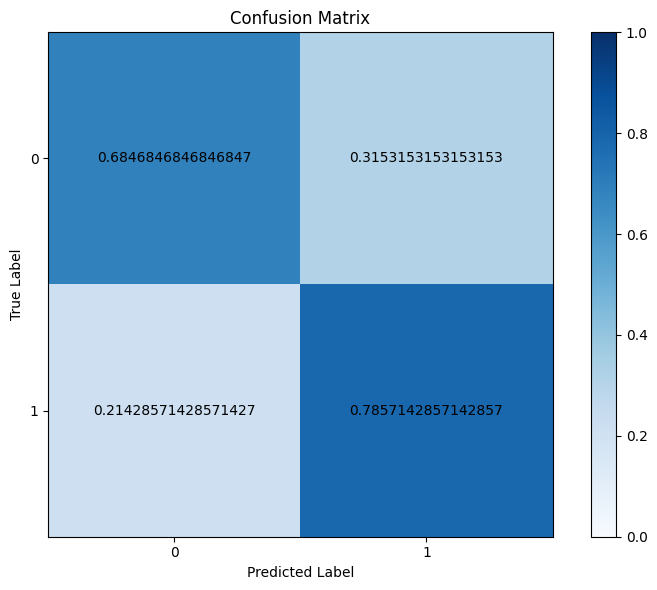

Train tracks shape:  (1108, 13)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_10          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7121 - loss: 0.8704 - val_accuracy: 0.4855 - val_loss: 0.6738
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5939 - loss: 0.7614 - val_accuracy: 0.2464 - val_loss: 0.8232
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.5806 - loss: 0.7104 - val_accuracy: 0.2391 - val_loss: 0.7963
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5952 - loss: 0.7104 - val_accuracy: 0.3188 - val_loss: 0.7668
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.5358 - loss: 0.6661 - val_accuracy: 0.3623 - val_loss: 0.7414
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.5631 - loss: 0.7034 - val_accuracy: 0.4348 - val_loss: 0.7111
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.5736 - loss: 0.6862 - val_accuracy: 0.4565 - val_loss: 0.6964
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.5983 - loss: 0.6839 - val_accuracy: 0.4493 -

In [4]:
conf_matrix_cellfate = data_size_study(dataset_size, train_images, train_labels, train_tracks, test_images, test_labels, test_tracks, x_train_full, seed=44)

In [19]:
conf_matrix_cellfate5 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/split_0.5/confusion_matrices_cellfate.npy")
conf_matrix_cellfate9 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/split_0.9/confusion_matrices_cellfate.npy")
conf_matrix_cellfate1 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/split_1.0/confusion_matrices_cellfate.npy")

conf_matrix_cellfate_seed42 = np.concatenate([conf_matrix_cellfate5, conf_matrix_cellfate9[:-1], conf_matrix_cellfate1], axis=0)

conf_matrix_cellfate_seed43_9 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/seed43_split_0.9/confusion_matrices_cellfate.npy")
conf_matrix_cellfate_seed43_1 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/seed43_split_1.0/confusion_matrices_cellfate.npy")

conf_matrix_cellfate_seed43 = np.concatenate([conf_matrix_cellfate_seed43_9[:-1], conf_matrix_cellfate_seed43_1], axis=0)

conf_matrix_cellfate_seed44_9 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/seed44_split_0.9/confusion_matrices_cellfate.npy")
conf_matrix_cellfate_seed44_1 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/seed44_split_1.0/confusion_matrices_cellfate.npy")

conf_matrix_cellfate_seed44 = np.concatenate([conf_matrix_cellfate_seed44_9[:-1], conf_matrix_cellfate_seed44_1], axis=0)

conf_matrix_cellfate = np.stack((conf_matrix_cellfate_seed42, conf_matrix_cellfate_seed43, conf_matrix_cellfate_seed44), axis=0)

In [30]:
conf_matrix_cellfate[0]

array([[[0.52252252, 0.47747748],
        [0.32142857, 0.67857143]],

       [[0.54054054, 0.45945946],
        [0.21428571, 0.78571429]],

       [[0.63963964, 0.36036036],
        [0.46428571, 0.53571429]],

       [[0.57657658, 0.42342342],
        [0.25      , 0.75      ]],

       [[0.63063063, 0.36936937],
        [0.25      , 0.75      ]],

       [[0.72072072, 0.27927928],
        [0.57142857, 0.42857143]],

       [[0.67567568, 0.32432432],
        [0.25      , 0.75      ]],

       [[0.6036036 , 0.3963964 ],
        [0.25      , 0.75      ]],

       [[0.64864865, 0.35135135],
        [0.35714286, 0.64285714]],

       [[0.65765766, 0.34234234],
        [0.39285714, 0.60714286]]])

In [33]:
# Get confusion matrices and plot precisions 

precision_cellfate = np.zeros((10, 3))
accuracy_cellfate = np.zeros((10, 3))
false_positives_cellfate = np.zeros((10, 3))
false_negatives_cellfate = np.zeros((10, 3))

for size in range(conf_matrix_cellfate.shape[1]):
    for seed in range(conf_matrix_cellfate.shape[0]):
        conf_matrix = conf_matrix_cellfate[seed, size]
        precision_cellfate[size, seed] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
        accuracy_cellfate[size, seed] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
        false_positives_cellfate[size, seed] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
        false_negatives_cellfate[size, seed] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])

In [34]:
mean_precisions = np.mean(precision_cellfate, axis=1)
std_precisions = np.std(precision_cellfate, axis=1)

mean_accuracies = np.mean(accuracy_cellfate, axis=1)
std_accuracies = np.std(accuracy_cellfate, axis=1)

mean_false_positives = np.mean(false_positives_cellfate, axis=1)
std_false_positives = np.std(false_positives_cellfate, axis=1)

mean_false_negatives = np.mean(false_negatives_cellfate, axis=1)
std_false_negatives = np.std(false_negatives_cellfate, axis=1)

In [35]:
precision_cellfate

array([[0.61913839, 0.50785973, 0.49430524],
       [0.71611253, 0.50611791, 0.48049922],
       [0.57942291, 0.67256637, 0.51836853],
       [0.69754768, 0.63843648, 0.52462527],
       [0.71611253, 0.71018277, 0.58113208],
       [0.55776892, 0.7606727 , 0.56184211],
       [0.72992701, 0.72592593, 0.70080863],
       [0.70712401, 0.58113208, 0.59475606],
       [0.64491363, 0.58736059, 0.7109375 ],
       [0.62603369, 0.69421488, 0.76163207]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


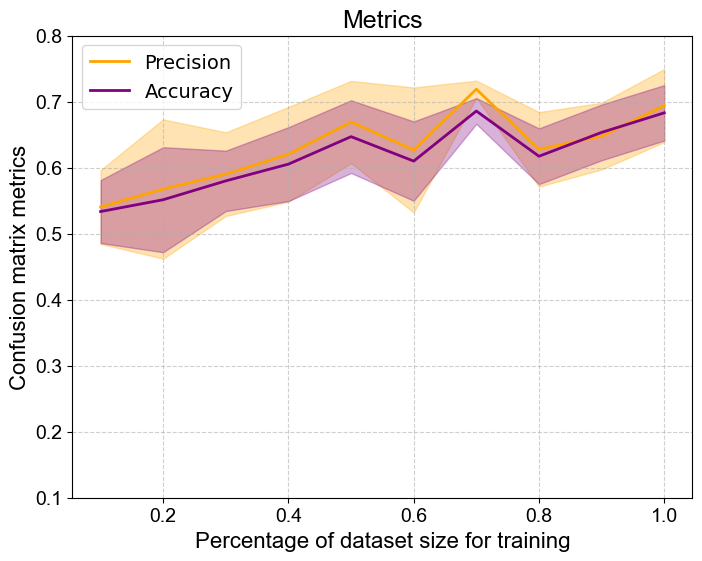

In [ ]:
sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
plt.plot(sizes, mean_precisions, color='orange', linewidth=2, label='Precision')
plt.fill_between(sizes, mean_precisions - std_precisions, mean_precisions + std_precisions,
                 color='orange', alpha=0.3)

# Accuracy (purple)
plt.plot(sizes, mean_accuracies, color='purple', linewidth=2, label='Accuracy')
plt.fill_between(sizes, mean_accuracies - std_accuracies, mean_accuracies + std_accuracies,
                 color='purple', alpha=0.3)

# # False Positives (green)
# plt.plot(sizes, mean_false_positives, color='green', linewidth=2, label='False Positives')
# plt.fill_between(sizes, mean_false_positives - std_false_positives, mean_false_positives + std_false_positives,
#                  color='green', alpha=0.3)

# # False Negatives (blue)
# plt.plot(sizes, mean_false_negatives, color='blue', linewidth=2, label='False Negatives')
# plt.fill_between(sizes, mean_false_negatives - std_false_negatives, mean_false_negatives + std_false_negatives,
#                  color='blue', alpha=0.3)

# Formatting
plt.xlabel("Percentage of dataset size for training", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix metrics", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.1, 0.8)  # Set y-axis range
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=14)
# Save the figure with high quality
#plt.savefig("data_labelling_random.eps", dpi=300, bbox_inches="tight")
plt.show()

# Taking cumulative set of data
Wanted to see if it would make a difference taking the first 10%, then the first 20%, etc rather than a random subset of X% of data (like above)

In [60]:
train_images[:int(train_images.shape[0]*0.9)].shape

(997, 1080, 20, 20)

In [3]:
dataset_size = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

def data_size_study_cummulative(dataset_size, train_images, train_labels, train_tracks, test_images, test_labels, test_tracks, x_train_full, seed=43):

    np.random.seed(seed)
    confusion_matrices_cellfate = np.zeros((len(dataset_size), 2, 2))

    for size in dataset_size:
        
        # Create new output directory folder with the size 
        output_dir=f"../results/data_labelling_study/cumulative_split_seed43_{size}"
        os.makedirs(output_dir, exist_ok=True)

        #less_indexes = np.random.choice(np.arange(len(train_labels)), int(size * len(train_labels)), replace=False)

        # Get less training data
        smaller_x_train_images = train_images[:int(train_images.shape[0]*size)]
        smaller_y_train = train_labels[:int(train_images.shape[0]*size)]

        # Augment image data
        smaller_train_images_augmented, smaller_train_labels_augmented = augment_dataset(smaller_x_train_images, smaller_y_train, augmentations)

        # Stretch intensities of new images (train and test)
        stretched_x_train_smaller, stretched_x_test = stretch_intensities_global(smaller_train_images_augmented, test_images)

        # Pick only frame zero
        x_train = stretched_x_train_smaller[:,0,:,:]
        y_train = smaller_train_labels_augmented
        x_test = stretched_x_test[:,0,:,:]
        y_test = test_labels

        print("X_train size: ", x_train.shape, "Y_train size: ", y_train.shape, "X_test size: ", x_test.shape, "Y_test size: ", y_test.shape)

        # IMAGES: Train autoencoder only
        
        config_ae = {
            'batch_size': 30,
            'epochs': 15,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 5,
            'lambda_adv': 1,
        }

        config_cellfate = {
            'batch_size': 30,
            'epochs': 100,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 6,
            'lambda_adv': 4,
            'lambda_cov': 0.0001,
            'lambda_contra': 8,
        }

        config_clf = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
        }

        results_autoencoder = train_autoencoder(config_ae, x_train_full)
        encoder = results_autoencoder['encoder']
        decoder = results_autoencoder['decoder']
        discriminator = results_autoencoder['discriminator']

        # IMAGES: Train AIcellfate with smaller dataset

        results_cellfate = train_cellfate(config_cellfate, encoder, decoder, discriminator, x_train, y_train, x_test, y_test) #lambda_recon=scaled_autoencoder_results['lambda_recon'], lambda_adv=scaled_autoencoder_results['lambda_adv']
        encoder = results_cellfate['encoder']
        decoder = results_cellfate['decoder']
        discriminator = results_cellfate['discriminator']

        save_model_weights_to_disk(encoder, decoder, discriminator, output_dir=output_dir)
        
        evaluator = Evaluation(output_dir)

        # Evaluate the model (and saving everything)
        z_imgs = encoder.predict(x_train)
        recon_imgs = decoder.predict(z_imgs)
        evaluator.reconstruction_images(x_train, recon_imgs[:,:,:,0], epoch=0)
        evaluator.visualize_latent_space(z_imgs, y_train, epoch=0)
     
        tf.keras.utils.set_random_seed(config_clf['seed'])

        classifier = mlp_classifier(latent_dim=config_clf['latent_dim'])
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_clf['learning_rate']), metrics=['accuracy'])

        x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) 
        history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config_clf['batch_size'], epochs=config_clf['epochs'], validation_data=(x_val, y_val)) 

        y_pred = classifier.predict(x_test_)
        y_pred_classes = np.argmax(y_pred, axis=1)
        num_classes = len(np.unique(y_test_))

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums
        
        confusion_matrices_cellfate[dataset_size.index(size)] = conf_matrix_normalized

        # Save confusion matrix
        plot_confusion_matrix(y_test_, y_pred, num_classes)
        np.save(f"{output_dir}/confusion_matrices_cellfate.npy", confusion_matrices_cellfate)

    return confusion_matrices_cellfate



X_train size:  (2184, 20, 20) Y_train size:  (2184,) X_test size:  (277, 20, 20) Y_test size:  (277,)
Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 43, latent dim: 2


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.3084, Adversarial loss: 0.7611, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.7899, Adversarial loss: 0.7317, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7731, Adversarial loss: 0.7214, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7688, Adversarial loss: 0.7100, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7335, Adversarial loss: 0.7051, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7432, Adversarial loss: 0.6976, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7405, Adversarial loss: 0.7011, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7117, Adversarial loss: 0.6965, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7207, Adversarial loss: 0.6985, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Training with batch size: 30, epochs: 100, learning rate: 0.001, seed: 43, latent dim: 2
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
kl_divergence[0]: 0.20164563389659856 kl_divergence[1]: 0.1396291548162274
Epoch 1/100: Reconstruction loss: 0.9032, Adversarial loss: 2.8177, Contrastive loss: 5.4938, Covariance loss: 0.0000, lamdba recon: 6.0000, lambda adv: 4.0000, lambda cov: 0.0001, lambda contra: 8.0000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
kl_divergence[0]: 0.17014914286824231 kl_divergence[1]: 0.6999924740997261
Epoch 2/100: Reconstruction loss: 0.9670, Adversarial loss: 2.8112, Contrastive loss: 5.2909, Covariance loss: 0.0000, lamdba recon: 6.0000, lambda adv: 4.0000, lambda cov: 0.0001, lambda contra: 8.0000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
kl_divergence[0]: 0.38069771332969027 kl_divergence[1]: 0.07764056476120922
Epoch 3/100: Reconstruction loss: 1.0295, Advers

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_5 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6247 - loss: 0.6913 - val_accuracy: 0.6449 - val_loss: 0.6411
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6297 - loss: 0.6684 - val_accuracy: 0.6159 - val_loss: 0.6490
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.6546 - loss: 0.6377 - val_accuracy: 0.6232 - val_loss: 0.6530
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.6340 - loss: 0.6405 - val_accuracy: 0.5942 - val_loss: 0.6532
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.6360 - loss: 0.6449 - val_accuracy: 0.5652 - val_loss: 0.6545
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.6316 - loss: 0.6403 - val_accuracy: 0.5725 - val_loss: 0.6518
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - accuracy: 0.6412 - loss: 0.6305 - val_accuracy: 0.5725 - val_loss: 0.6508
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6371 - loss: 0.6358 - val_accuracy: 0.5652

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_6 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4982 - loss: 0.8145 - val_accuracy: 0.5870 - val_loss: 0.6575
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5080 - loss: 0.7480 - val_accuracy: 0.6014 - val_loss: 0.6610
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.5271 - loss: 0.7312 - val_accuracy: 0.5942 - val_loss: 0.6625
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.5381 - loss: 0.6988 - val_accuracy: 0.5870 - val_loss: 0.6617
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.5705 - loss: 0.6709 - val_accuracy: 0.5725 - val_loss: 0.6585
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.5957 - loss: 0.6597 - val_accuracy: 0.5797 - val_loss: 0.6567
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.6391 - loss: 0.6483 - val_accuracy: 0.5725 - val_loss: 0.6536
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6537 - loss: 0.6375 - val_accuracy: 0.5797

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_7 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6060 - loss: 1.0225 - val_accuracy: 0.7609 - val_loss: 0.5621
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.6403 - loss: 0.9299 - val_accuracy: 0.7609 - val_loss: 0.5623
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6246 - loss: 0.8883 - val_accuracy: 0.7536 - val_loss: 0.5642
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6394 - loss: 0.8195 - val_accuracy: 0.7536 - val_loss: 0.5690
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.6389 - loss: 0.7738 - val_accuracy: 0.7681 - val_loss: 0.5745
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.6320 - loss: 0.8092 - val_accuracy: 0.7681 - val_loss: 0.5801
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.6528 - loss: 0.7590 - val_accuracy: 0.7464 - val_loss: 0.5870
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.6498 - loss: 0.7186 - val_accuracy: 0.76

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6130 - loss: 0.6695 - val_accuracy: 0.6014 - val_loss: 0.6521
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6209 - loss: 0.6608 - val_accuracy: 0.5942 - val_loss: 0.6452
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.6232 - loss: 0.6465 - val_accuracy: 0.6087 - val_loss: 0.6403
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.6235 - loss: 0.6456 - val_accuracy: 0.6087 - val_loss: 0.6354
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.6366 - loss: 0.6330 - val_accuracy: 0.6232 - val_loss: 0.6332
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6125 - loss: 0.6418 - val_accuracy: 0.6304 - val_loss: 0.6329
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6006 - loss: 0.6506 - val_accuracy: 0.6232 - val_loss: 0.6326
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.6112 - loss: 0.6438 - val_accuracy: 0.6232

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_9 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5678 - loss: 0.8062 - val_accuracy: 0.5000 - val_loss: 0.8654
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.5935 - loss: 0.7523 - val_accuracy: 0.5145 - val_loss: 0.8093
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - accuracy: 0.5826 - loss: 0.7441 - val_accuracy: 0.5217 - val_loss: 0.7652
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.5952 - loss: 0.7131 - val_accuracy: 0.5362 - val_loss: 0.7298
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6161 - loss: 0.6807 - val_accuracy: 0.5580 - val_loss: 0.7027
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.5939 - loss: 0.6857 - val_accuracy: 0.5652 - val_loss: 0.6782
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6046 - loss: 0.6744 - val_accuracy: 0.6014 - val_loss: 0.6595
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.6144 - loss: 0.6570 - val_accuracy: 0.63

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_10 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4839 - loss: 1.1819 - val_accuracy: 0.4203 - val_loss: 1.1111
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4447 - loss: 1.0950 - val_accuracy: 0.4275 - val_loss: 1.0566
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.4552 - loss: 1.0690 - val_accuracy: 0.4348 - val_loss: 1.0038
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.4702 - loss: 1.0374 - val_accuracy: 0.4348 - val_loss: 0.9528
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.4898 - loss: 0.9489 - val_accuracy: 0.4348 - val_loss: 0.9104
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.4682 - loss: 0.9180 - val_accuracy: 0.4420 - val_loss: 0.8712
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.4848 - loss: 0.8851 - val_accuracy: 0.4565 - val_loss: 0.8346
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.4851 - loss: 0.8485 - val_accuracy: 0.4783

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_11 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5535 - loss: 0.7190 - val_accuracy: 0.6812 - val_loss: 0.6016
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5688 - loss: 0.6988 - val_accuracy: 0.6739 - val_loss: 0.6030
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.5620 - loss: 0.6850 - val_accuracy: 0.6812 - val_loss: 0.6034
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - accuracy: 0.5856 - loss: 0.6711 - val_accuracy: 0.6884 - val_loss: 0.6069
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.5796 - loss: 0.6614 - val_accuracy: 0.6884 - val_loss: 0.6075
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.6108 - loss: 0.6470 - val_accuracy: 0.6812 - val_loss: 0.6048
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.6144 - loss: 0.6410 - val_accuracy: 0.6812 - val_loss: 0.6055
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6056 - loss: 0.6438 - val_accuracy: 0.6812

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_12 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3711 - loss: 1.6416 - val_accuracy: 0.5145 - val_loss: 0.9979
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3758 - loss: 1.5204 - val_accuracy: 0.5000 - val_loss: 0.9775
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.3739 - loss: 1.3962 - val_accuracy: 0.5000 - val_loss: 0.9583
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.3768 - loss: 1.3601 - val_accuracy: 0.4710 - val_loss: 0.9384
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.3704 - loss: 1.2309 - val_accuracy: 0.4710 - val_loss: 0.9210
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.3883 - loss: 1.1494 - val_accuracy: 0.4493 - val_loss: 0.9023
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.3849 - loss: 1.0806 - val_accuracy: 0.4275 - val_loss: 0.8821
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.3892 - loss: 0.9698 - val_accuracy: 0.4130

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_13 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5506 - loss: 1.1448 - val_accuracy: 0.5435 - val_loss: 0.8219
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.5629 - loss: 1.0261 - val_accuracy: 0.5435 - val_loss: 0.8244
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.5564 - loss: 0.9786 - val_accuracy: 0.5362 - val_loss: 0.8248
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.5675 - loss: 0.9320 - val_accuracy: 0.5217 - val_loss: 0.8219
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.5782 - loss: 0.8806 - val_accuracy: 0.5290 - val_loss: 0.8139
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.5847 - loss: 0.8248 - val_accuracy: 0.5362 - val_loss: 0.8069
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.5964 - loss: 0.8181 - val_accuracy: 0.5290 - val_loss: 0.7934
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.5937 - loss: 0.7789 - val_accuracy: 0.52

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_14 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6764 - loss: 0.6431 - val_accuracy: 0.7246 - val_loss: 0.6402
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.6610 - loss: 0.6279 - val_accuracy: 0.7319 - val_loss: 0.6252
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6502 - loss: 0.6250 - val_accuracy: 0.7319 - val_loss: 0.6164
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.6587 - loss: 0.6172 - val_accuracy: 0.7319 - val_loss: 0.6092
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.6809 - loss: 0.6128 - val_accuracy: 0.7391 - val_loss: 0.6039
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6739 - loss: 0.6029 - val_accuracy: 0.7391 - val_loss: 0.6004
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.6788 - loss: 0.6054 - val_accuracy: 0.7391 - val_loss: 0.5991
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6688 - loss: 0.6074 - val_accuracy: 0.7391

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_15 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4078 - loss: 1.2121 - val_accuracy: 0.4710 - val_loss: 0.9749
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4132 - loss: 1.1024 - val_accuracy: 0.4855 - val_loss: 0.8828
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.4149 - loss: 0.9914 - val_accuracy: 0.5000 - val_loss: 0.8031
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.5140 - loss: 0.9090 - val_accuracy: 0.5072 - val_loss: 0.7414
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.5303 - loss: 0.8345 - val_accuracy: 0.5507 - val_loss: 0.6918
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.5445 - loss: 0.7744 - val_accuracy: 0.5942 - val_loss: 0.6543
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.5572 - loss: 0.7303 - val_accuracy: 0.6377 - val_loss: 0.6297
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.6072 - loss: 0.6944 - val_accuracy: 0.7029

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_16 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3927 - loss: 0.7824 - val_accuracy: 0.4348 - val_loss: 0.7352
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.4074 - loss: 0.7379 - val_accuracy: 0.4275 - val_loss: 0.7213
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5153 - loss: 0.7027 - val_accuracy: 0.4493 - val_loss: 0.7078
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.6189 - loss: 0.6738 - val_accuracy: 0.5145 - val_loss: 0.6951
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6324 - loss: 0.6574 - val_accuracy: 0.5797 - val_loss: 0.6841
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6522 - loss: 0.6402 - val_accuracy: 0.6159 - val_loss: 0.6733
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6474 - loss: 0.6386 - val_accuracy: 0.6377 - val_loss: 0.6642
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6500 - loss: 0.6318 - val_accuracy: 0.6522

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_17 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3381 - loss: 1.1075 - val_accuracy: 0.2971 - val_loss: 0.9765
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.3368 - loss: 1.0294 - val_accuracy: 0.3116 - val_loss: 0.9200
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.3154 - loss: 0.9821 - val_accuracy: 0.3261 - val_loss: 0.8675
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.3369 - loss: 0.9151 - val_accuracy: 0.3261 - val_loss: 0.8246
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.3562 - loss: 0.8400 - val_accuracy: 0.3478 - val_loss: 0.7877
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.3530 - loss: 0.8147 - val_accuracy: 0.3913 - val_loss: 0.7552
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.3825 - loss: 0.7711 - val_accuracy: 0.4275 - val_loss: 0.7306
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.3973 - loss: 0.7381 - val_accuracy: 0.52

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_18 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6155 - loss: 0.6822 - val_accuracy: 0.5652 - val_loss: 0.7037
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6297 - loss: 0.6490 - val_accuracy: 0.5870 - val_loss: 0.6812
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.6421 - loss: 0.6341 - val_accuracy: 0.6232 - val_loss: 0.6658
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6573 - loss: 0.6173 - val_accuracy: 0.6304 - val_loss: 0.6543
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.6616 - loss: 0.6074 - val_accuracy: 0.6449 - val_loss: 0.6485
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6685 - loss: 0.5942 - val_accuracy: 0.6522 - val_loss: 0.6446
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.6735 - loss: 0.6020 - val_accuracy: 0.6594 - val_loss: 0.6380
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6631 - loss: 0.5998 - val_accuracy: 0.65

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_19 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3140 - loss: 1.4444 - val_accuracy: 0.3986 - val_loss: 0.9636
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.3162 - loss: 1.3211 - val_accuracy: 0.3768 - val_loss: 0.9280
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.3238 - loss: 1.2377 - val_accuracy: 0.3696 - val_loss: 0.8935
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.3249 - loss: 1.1033 - val_accuracy: 0.3478 - val_loss: 0.8631
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.3105 - loss: 1.0276 - val_accuracy: 0.3551 - val_loss: 0.8308
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.3570 - loss: 0.9086 - val_accuracy: 0.3623 - val_loss: 0.8032
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accuracy: 0.3814 - loss: 0.8389 - val_accuracy: 0.3696 - val_loss: 0.7762
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.4228 - loss: 0.7796 - val_accuracy: 0.40

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_20 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5089 - loss: 0.8641 - val_accuracy: 0.6014 - val_loss: 0.7146
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.5581 - loss: 0.8022 - val_accuracy: 0.5942 - val_loss: 0.6821
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.5785 - loss: 0.7572 - val_accuracy: 0.6449 - val_loss: 0.6582
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6288 - loss: 0.7266 - val_accuracy: 0.6449 - val_loss: 0.6426
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.6379 - loss: 0.7121 - val_accuracy: 0.6522 - val_loss: 0.6331
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6255 - loss: 0.6828 - val_accuracy: 0.6377 - val_loss: 0.6253
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.6570 - loss: 0.6606 - val_accuracy: 0.6449 - val_loss: 0.6208
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.6565 - loss: 0.6396 - val_accuracy: 0.65

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_21 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4277 - loss: 1.9302 - val_accuracy: 0.3043 - val_loss: 1.9886
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4238 - loss: 1.8720 - val_accuracy: 0.3043 - val_loss: 1.8135
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.4161 - loss: 1.7671 - val_accuracy: 0.3261 - val_loss: 1.6481
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.4143 - loss: 1.5867 - val_accuracy: 0.3406 - val_loss: 1.4952
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.4189 - loss: 1.4220 - val_accuracy: 0.3478 - val_loss: 1.3533
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.4324 - loss: 1.3230 - val_accuracy: 0.3623 - val_loss: 1.2222
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.4208 - loss: 1.1910 - val_accuracy: 0.3768 - val_loss: 1.1031
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.4280 - loss: 1.1072 - val_accuracy: 0.3913

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_22 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3515 - loss: 1.0908 - val_accuracy: 0.4058 - val_loss: 0.8101
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.3737 - loss: 0.9961 - val_accuracy: 0.3696 - val_loss: 0.8129
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.3623 - loss: 0.9555 - val_accuracy: 0.3333 - val_loss: 0.8127
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.3610 - loss: 0.9024 - val_accuracy: 0.3116 - val_loss: 0.8097
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.3567 - loss: 0.8571 - val_accuracy: 0.2681 - val_loss: 0.8038
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.3631 - loss: 0.8217 - val_accuracy: 0.2536 - val_loss: 0.7940
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.3537 - loss: 0.7908 - val_accuracy: 0.2319 - val_loss: 0.7819
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.3874 - loss: 0.7564 - val_accuracy: 0.21

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_23 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6153 - loss: 0.8450 - val_accuracy: 0.5942 - val_loss: 0.7856
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.6327 - loss: 0.7576 - val_accuracy: 0.6087 - val_loss: 0.7549
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6218 - loss: 0.7531 - val_accuracy: 0.6014 - val_loss: 0.7290
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6429 - loss: 0.7179 - val_accuracy: 0.6087 - val_loss: 0.7054
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6303 - loss: 0.7001 - val_accuracy: 0.6304 - val_loss: 0.6822
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6493 - loss: 0.6660 - val_accuracy: 0.6377 - val_loss: 0.6621
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6418 - loss: 0.6615 - val_accuracy: 0.6449 - val_loss: 0.6442
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.6446 - loss: 0.6304 - val_accuracy: 0.66

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_24 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3191 - loss: 1.1357 - val_accuracy: 0.3406 - val_loss: 0.9923
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.3281 - loss: 1.0660 - val_accuracy: 0.3551 - val_loss: 0.9475
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.3297 - loss: 0.9947 - val_accuracy: 0.3478 - val_loss: 0.9102
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.2999 - loss: 0.9765 - val_accuracy: 0.3406 - val_loss: 0.8737
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.3201 - loss: 0.9111 - val_accuracy: 0.3261 - val_loss: 0.8420
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.3084 - loss: 0.8739 - val_accuracy: 0.3261 - val_loss: 0.8144
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.2928 - loss: 0.8467 - val_accuracy: 0.2971 - val_loss: 0.7881
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3301 - loss: 0.7952 - val_accuracy: 0.2971

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_25 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6474 - loss: 0.6786 - val_accuracy: 0.5652 - val_loss: 0.7914
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.6320 - loss: 0.6535 - val_accuracy: 0.5870 - val_loss: 0.7481
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.6710 - loss: 0.6225 - val_accuracy: 0.5942 - val_loss: 0.7114
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6578 - loss: 0.6219 - val_accuracy: 0.6087 - val_loss: 0.6798
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6597 - loss: 0.6013 - val_accuracy: 0.6159 - val_loss: 0.6609
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - accuracy: 0.6512 - loss: 0.6156 - val_accuracy: 0.6159 - val_loss: 0.6432
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6498 - loss: 0.6086 - val_accuracy: 0.6232 - val_loss: 0.6324
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6730 - loss: 0.5897 - val_accuracy: 0.6159 -

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_26 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6856 - loss: 0.5938 - val_accuracy: 0.6159 - val_loss: 0.6577
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.6906 - loss: 0.5931 - val_accuracy: 0.6232 - val_loss: 0.6359
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6846 - loss: 0.5760 - val_accuracy: 0.6377 - val_loss: 0.6251
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.7052 - loss: 0.5754 - val_accuracy: 0.6522 - val_loss: 0.6143
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6976 - loss: 0.5680 - val_accuracy: 0.6667 - val_loss: 0.6085
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6772 - loss: 0.5675 - val_accuracy: 0.6667 - val_loss: 0.6087
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.6910 - loss: 0.5620 - val_accuracy: 0.6667 - val_loss: 0.6083
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.6877 - loss: 0.5745 - val_accuracy: 0.67

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_27 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4848 - loss: 1.0489 - val_accuracy: 0.6522 - val_loss: 0.7027
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5533 - loss: 0.9705 - val_accuracy: 0.6739 - val_loss: 0.6798
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.5828 - loss: 0.9164 - val_accuracy: 0.6667 - val_loss: 0.6625
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6097 - loss: 0.8686 - val_accuracy: 0.6594 - val_loss: 0.6465
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6056 - loss: 0.7930 - val_accuracy: 0.6522 - val_loss: 0.6337
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6052 - loss: 0.7696 - val_accuracy: 0.6667 - val_loss: 0.6256
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6167 - loss: 0.7307 - val_accuracy: 0.6957 - val_loss: 0.6181
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6338 - loss: 0.6966 - val_accuracy: 0.7029

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_28 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6510 - loss: 0.6213 - val_accuracy: 0.5942 - val_loss: 0.7400
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.6675 - loss: 0.6000 - val_accuracy: 0.6522 - val_loss: 0.7045
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.6862 - loss: 0.5840 - val_accuracy: 0.6449 - val_loss: 0.6799
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6731 - loss: 0.5918 - val_accuracy: 0.6449 - val_loss: 0.6601
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6797 - loss: 0.5895 - val_accuracy: 0.6739 - val_loss: 0.6494
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.6679 - loss: 0.5913 - val_accuracy: 0.6957 - val_loss: 0.6401
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6722 - loss: 0.5834 - val_accuracy: 0.7101 - val_loss: 0.6367
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.6809 - loss: 0.5866 - val_accuracy: 0.71

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_29 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3069 - loss: 1.2893 - val_accuracy: 0.2971 - val_loss: 1.0177
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.3128 - loss: 1.2193 - val_accuracy: 0.2681 - val_loss: 0.9920
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.3296 - loss: 1.1084 - val_accuracy: 0.2681 - val_loss: 0.9629
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.3231 - loss: 1.0503 - val_accuracy: 0.2681 - val_loss: 0.9328
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.3164 - loss: 1.0070 - val_accuracy: 0.2826 - val_loss: 0.9013
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.3347 - loss: 0.9331 - val_accuracy: 0.2609 - val_loss: 0.8711
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.3334 - loss: 0.8957 - val_accuracy: 0.2536 - val_loss: 0.8411
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.3522 - loss: 0.8438 - val_accuracy: 0.26

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_30 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4400 - loss: 0.7877 - val_accuracy: 0.4058 - val_loss: 0.8201
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.5468 - loss: 0.7104 - val_accuracy: 0.4275 - val_loss: 0.7676
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6109 - loss: 0.6773 - val_accuracy: 0.5072 - val_loss: 0.7257
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6862 - loss: 0.6241 - val_accuracy: 0.5942 - val_loss: 0.6986
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6823 - loss: 0.6206 - val_accuracy: 0.6377 - val_loss: 0.6745
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6921 - loss: 0.6035 - val_accuracy: 0.6739 - val_loss: 0.6589
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.6900 - loss: 0.5926 - val_accuracy: 0.6667 - val_loss: 0.6481
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6907 - loss: 0.5839 - val_accuracy: 0.6667

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_31 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3463 - loss: 1.3545 - val_accuracy: 0.4058 - val_loss: 1.0165
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3424 - loss: 1.3149 - val_accuracy: 0.4130 - val_loss: 0.9839
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.3454 - loss: 1.2029 - val_accuracy: 0.4130 - val_loss: 0.9483
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.3514 - loss: 1.1365 - val_accuracy: 0.4058 - val_loss: 0.9172
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.3564 - loss: 1.0702 - val_accuracy: 0.3913 - val_loss: 0.8863
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.3437 - loss: 1.0214 - val_accuracy: 0.3768 - val_loss: 0.8554
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.3408 - loss: 0.9545 - val_accuracy: 0.3841 - val_loss: 0.8298
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.3328 - loss: 0.9081 - val_accuracy: 0.38

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_32 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3215 - loss: 1.1329 - val_accuracy: 0.2681 - val_loss: 1.0108
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3260 - loss: 1.0333 - val_accuracy: 0.2681 - val_loss: 0.9204
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.3009 - loss: 0.9469 - val_accuracy: 0.2971 - val_loss: 0.8454
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.3171 - loss: 0.8695 - val_accuracy: 0.3261 - val_loss: 0.7834
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.3044 - loss: 0.8075 - val_accuracy: 0.3406 - val_loss: 0.7356
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.2880 - loss: 0.7600 - val_accuracy: 0.4638 - val_loss: 0.6980
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.3517 - loss: 0.7129 - val_accuracy: 0.7826 - val_loss: 0.6726
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.5745 - loss: 0.6826 - val_accuracy: 0.7754

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_33 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6474 - loss: 0.7215 - val_accuracy: 0.7464 - val_loss: 0.5703
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6599 - loss: 0.6931 - val_accuracy: 0.7246 - val_loss: 0.5760
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6633 - loss: 0.6579 - val_accuracy: 0.7246 - val_loss: 0.5795
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.6797 - loss: 0.6375 - val_accuracy: 0.6957 - val_loss: 0.5845
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6845 - loss: 0.6240 - val_accuracy: 0.7029 - val_loss: 0.5866
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - accuracy: 0.6984 - loss: 0.5865 - val_accuracy: 0.6957 - val_loss: 0.5877
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.7060 - loss: 0.5909 - val_accuracy: 0.7101 - val_loss: 0.5873
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - accuracy: 0.6972 - loss: 0.5965 - val_accuracy: 0.7029

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_34 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3322 - loss: 1.7945 - val_accuracy: 0.4420 - val_loss: 1.0704
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3278 - loss: 1.6810 - val_accuracy: 0.4348 - val_loss: 1.0575
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.3342 - loss: 1.5677 - val_accuracy: 0.4203 - val_loss: 1.0432
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3191 - loss: 1.4865 - val_accuracy: 0.4058 - val_loss: 1.0255
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.2943 - loss: 1.4520 - val_accuracy: 0.3841 - val_loss: 1.0051
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3182 - loss: 1.2907 - val_accuracy: 0.3551 - val_loss: 0.9854
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.3192 - loss: 1.2516 - val_accuracy: 0.3551 - val_loss: 0.9658
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.3072 - loss: 1.1697 - val_accuracy: 0.3551

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_35 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6682 - loss: 0.6665 - val_accuracy: 0.5797 - val_loss: 0.7893
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6747 - loss: 0.6451 - val_accuracy: 0.6159 - val_loss: 0.7565
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6968 - loss: 0.6132 - val_accuracy: 0.6232 - val_loss: 0.7319
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6926 - loss: 0.6014 - val_accuracy: 0.6304 - val_loss: 0.7108
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6897 - loss: 0.5893 - val_accuracy: 0.6377 - val_loss: 0.6932
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6781 - loss: 0.6035 - val_accuracy: 0.6377 - val_loss: 0.6787
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.7037 - loss: 0.5700 - val_accuracy: 0.6377 - val_loss: 0.6670
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6876 - loss: 0.5814 - val_accuracy: 0.6449

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


kl_divergence[0]: 0.09026975113072298 kl_divergence[1]: 0.25644225055946746
Epoch 100/100: Reconstruction loss: 1.0936, Adversarial loss: 2.8504, Contrastive loss: 3.8823, Covariance loss: 0.0000, lamdba recon: 6.0000, lambda adv: 4.0000, lambda cov: 0.0001, lambda contra: 8.0000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Reconstruction images saved to ../results/data_labelling_study/cumulative_split_seed43_1.0/reconstruction_images.png
Top correlated features: 1, 0
Latent space visualization saved to ../results/data_labelling_study/cumulative_split_seed43_1.0/latent_space.png
Covariance matrix saved to ../results/data_labelling_study/cumulative_split_seed43_1.0/cov_matrix.png
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7074 - loss: 0.5677 - val_accuracy: 0.5942 - val_loss: 0.6942
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.7139 - los

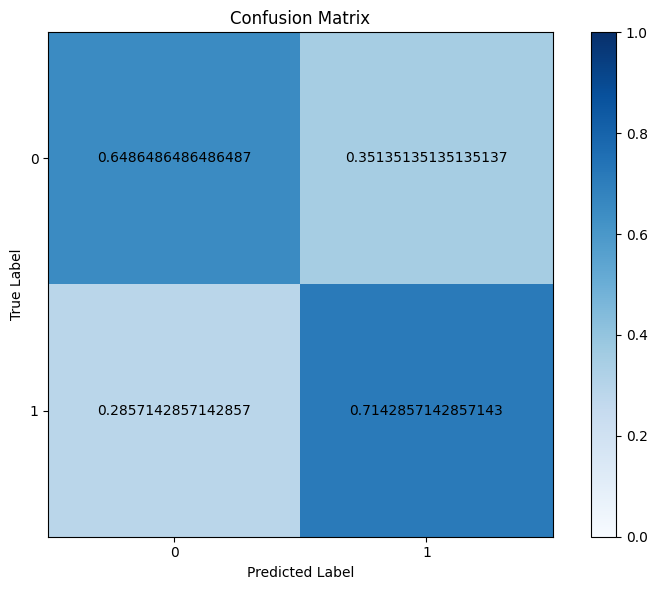

Train tracks shape:  (1108, 13)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_10          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5363 - loss: 0.7002 - val_accuracy: 0.2246 - val_loss: 0.8477
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6131 - loss: 0.6519 - val_accuracy: 0.2899 - val_loss: 0.8388
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.6155 - loss: 0.6501 - val_accuracy: 0.3551 - val_loss: 0.8077
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.6157 - loss: 0.6709 - val_accuracy: 0.4275 - val_loss: 0.7589
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.6614 - loss: 0.6352 - val_accuracy: 0.4420 - val_loss: 0.7244
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.6810 - loss: 0.6374 - val_accuracy: 0.4420 - val_loss: 0.7057
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.6423 - loss: 0.6290 - val_accuracy: 0.5000 - val_loss: 0.6802
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6284 - loss: 0.6290 - val_accuracy: 0.5217 -

In [4]:
conf_matrix_cellfate = data_size_study_cummulative(dataset_size, train_images, train_labels, train_tracks, test_images, test_labels, test_tracks, x_train_full, seed=43)

In [37]:
cumulative_cellfate_seed42_09 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_0.9/confusion_matrices_cellfate.npy")
cumulative_cellfate_seed42_1 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_1.0/confusion_matrices_cellfate.npy")

cumulative_cellfate_seed42 = np.concatenate([cumulative_cellfate_seed42_09[:9], cumulative_cellfate_seed42_1], axis=0)

cumulative_cellfate_seed43_09 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed43_0.9/confusion_matrices_cellfate.npy")
cumulative_cellfate_seed43_1 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed43_1.0/confusion_matrices_cellfate.npy")

cumulative_cellfate_seed43 = np.concatenate([cumulative_cellfate_seed43_09[:9], cumulative_cellfate_seed43_1], axis=0)

cumulative_cellfate_seed44_06 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed44_0.6/confusion_matrices_cellfate.npy")
cumulative_cellfate_seed44_07 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed44_0.7/confusion_matrices_cellfate.npy")
cumulative_cellfate_seed44_08 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed44_0.8/confusion_matrices_cellfate.npy")
cumulative_cellfate_seed44_09 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed44_0.9/confusion_matrices_cellfate.npy")
cumulative_cellfate_seed44_1 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed44_1.0/confusion_matrices_cellfate.npy")

cumulative_cellfate_seed44 = np.concatenate([cumulative_cellfate_seed44_06[:6], cumulative_cellfate_seed44_07[0].reshape(1,2,2), cumulative_cellfate_seed44_08[0].reshape(1,2,2), cumulative_cellfate_seed44_09[0].reshape(1,2,2), cumulative_cellfate_seed44_1], axis=0)

In [39]:
conf_matrix_cellfate = np.stack((cumulative_cellfate_seed42, cumulative_cellfate_seed43, cumulative_cellfate_seed44), axis=0)

In [40]:
conf_matrix_cellfate.shape

(3, 10, 2, 2)

In [41]:
# Get confusion matrices and plot precisions 

precision_cellfate = np.zeros((10, 3))
accuracy_cellfate = np.zeros((10, 3))
false_positives_cellfate = np.zeros((10, 3))
false_negatives_cellfate = np.zeros((10, 3))

for size in range(conf_matrix_cellfate.shape[1]):
    for seed in range(conf_matrix_cellfate.shape[0]):
        conf_matrix = conf_matrix_cellfate[seed, size]
        precision_cellfate[size, seed] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
        accuracy_cellfate[size, seed] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
        false_positives_cellfate[size, seed] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
        false_negatives_cellfate[size, seed] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])

In [43]:
mean_precisions = np.mean(precision_cellfate, axis=1)
std_precisions = np.std(precision_cellfate, axis=1)

mean_accuracies = np.mean(accuracy_cellfate, axis=1)
std_accuracies = np.std(accuracy_cellfate, axis=1)

mean_false_positives = np.mean(false_positives_cellfate, axis=1)
std_false_positives = np.std(false_positives_cellfate, axis=1)

mean_false_negatives = np.mean(false_negatives_cellfate, axis=1)
std_false_negatives = np.std(false_negatives_cellfate, axis=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


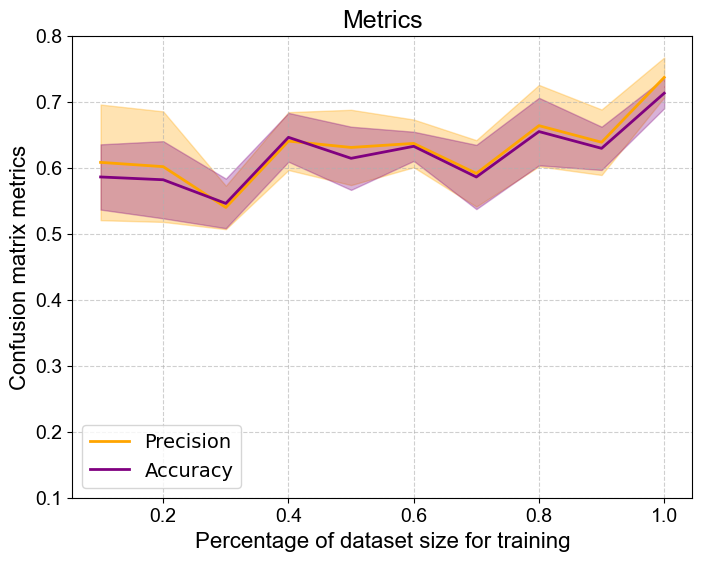

In [ ]:
sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
plt.plot(sizes, mean_precisions, color='orange', linewidth=2, label='Precision')
plt.fill_between(sizes, mean_precisions - std_precisions, mean_precisions + std_precisions,
                 color='orange', alpha=0.3)

# Accuracy (purple)
plt.plot(sizes, mean_accuracies, color='purple', linewidth=2, label='Accuracy')
plt.fill_between(sizes, mean_accuracies - std_accuracies, mean_accuracies + std_accuracies,
                 color='purple', alpha=0.3)

# # False Positives (green)
# plt.plot(sizes, mean_false_positives, color='green', linewidth=2, label='False Positives')
# plt.fill_between(sizes, mean_false_positives - std_false_positives, mean_false_positives + std_false_positives,
#                  color='green', alpha=0.3)

# # False Negatives (blue)
# plt.plot(sizes, mean_false_negatives, color='blue', linewidth=2, label='False Negatives')
# plt.fill_between(sizes, mean_false_negatives - std_false_negatives, mean_false_negatives + std_false_negatives,
#                  color='blue', alpha=0.3)

# Formatting
plt.xlabel("Percentage of dataset size for training", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix metrics", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.1, 0.8)  # Set y-axis range
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=14)
# Save the figure with high quality
#plt.savefig("cumulative_data_labelling_SI.eps", dpi=300, bbox_inches="tight")
plt.show()

# Figure 2B - Visualising Latent Spaces and Confusion Matrices

## 20% labelled data for training

In [5]:
confusion_matrices_split02 = np.zeros((3,2,2))
confusion_matrices_split02[0] = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/split_0.2/confusion_matrices_cellfate.npy")[1]
confusion_matrices_split02[1] = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/seed43_split_0.2/confusion_matrices_cellfate.npy")[1]
confusion_matrices_split02[2] = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/seed44_split_0.2/confusion_matrices_cellfate.npy")[1]

In [6]:
print("Mean",np.mean(confusion_matrices_split02,axis=0))
print("Std",np.std(confusion_matrices_split02,axis=0))

Mean [[0.50750751 0.49249249]
 [0.4047619  0.5952381 ]]
Std [[0.08069086 0.08069086]
 [0.14677176 0.14677176]]


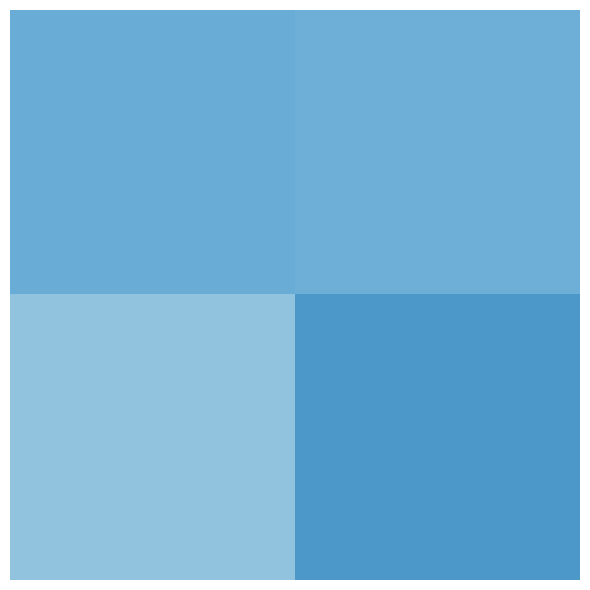

In [7]:
plt.figure(figsize=(8, 6))
plt.imshow(np.mean(confusion_matrices_split02, axis=0), interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.axis('off')
plt.tight_layout()
#plt.savefig("mean_confmatrix_split02.pdf", format="pdf", dpi=300, pad_inches=0)
plt.show()

In [10]:
from src.preprocessing.preprocessing_functions import *

config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
    'lambda_recon': 5, 
    'lambda_adv': 0.05,
    'lambda_clf': 0.05,
    'lambda_cov': 0.1,
}

size = 0.2
np.random.seed(config['seed'])
less_indexes = np.random.choice(np.arange(len(train_labels)), int(size * len(train_labels)), replace=False)

smaller_x_train_images = train_images[less_indexes]
smaller_y_train = train_labels[less_indexes]
smaller_x_train_tracks = train_tracks[less_indexes]

# Augment image data
smaller_train_images_augmented, smaller_train_labels_augmented = augment_dataset(smaller_x_train_images, smaller_y_train, augmentations)

# Stretch intensities of new images (train and test)
stretched_x_train_smaller, stretched_x_test = stretch_intensities_global(smaller_train_images_augmented, test_images)

# Pick only frame zero
x_train = stretched_x_train_smaller[:,0,:,:]
y_train = smaller_train_labels_augmented
x_test = stretched_x_test[:,0,:,:]
y_test = test_labels

img_shape = (x_train.shape[1], x_train.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

encoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/split_0.2/encoder.weights.h5")
decoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/split_0.2/decoder.weights.h5")

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


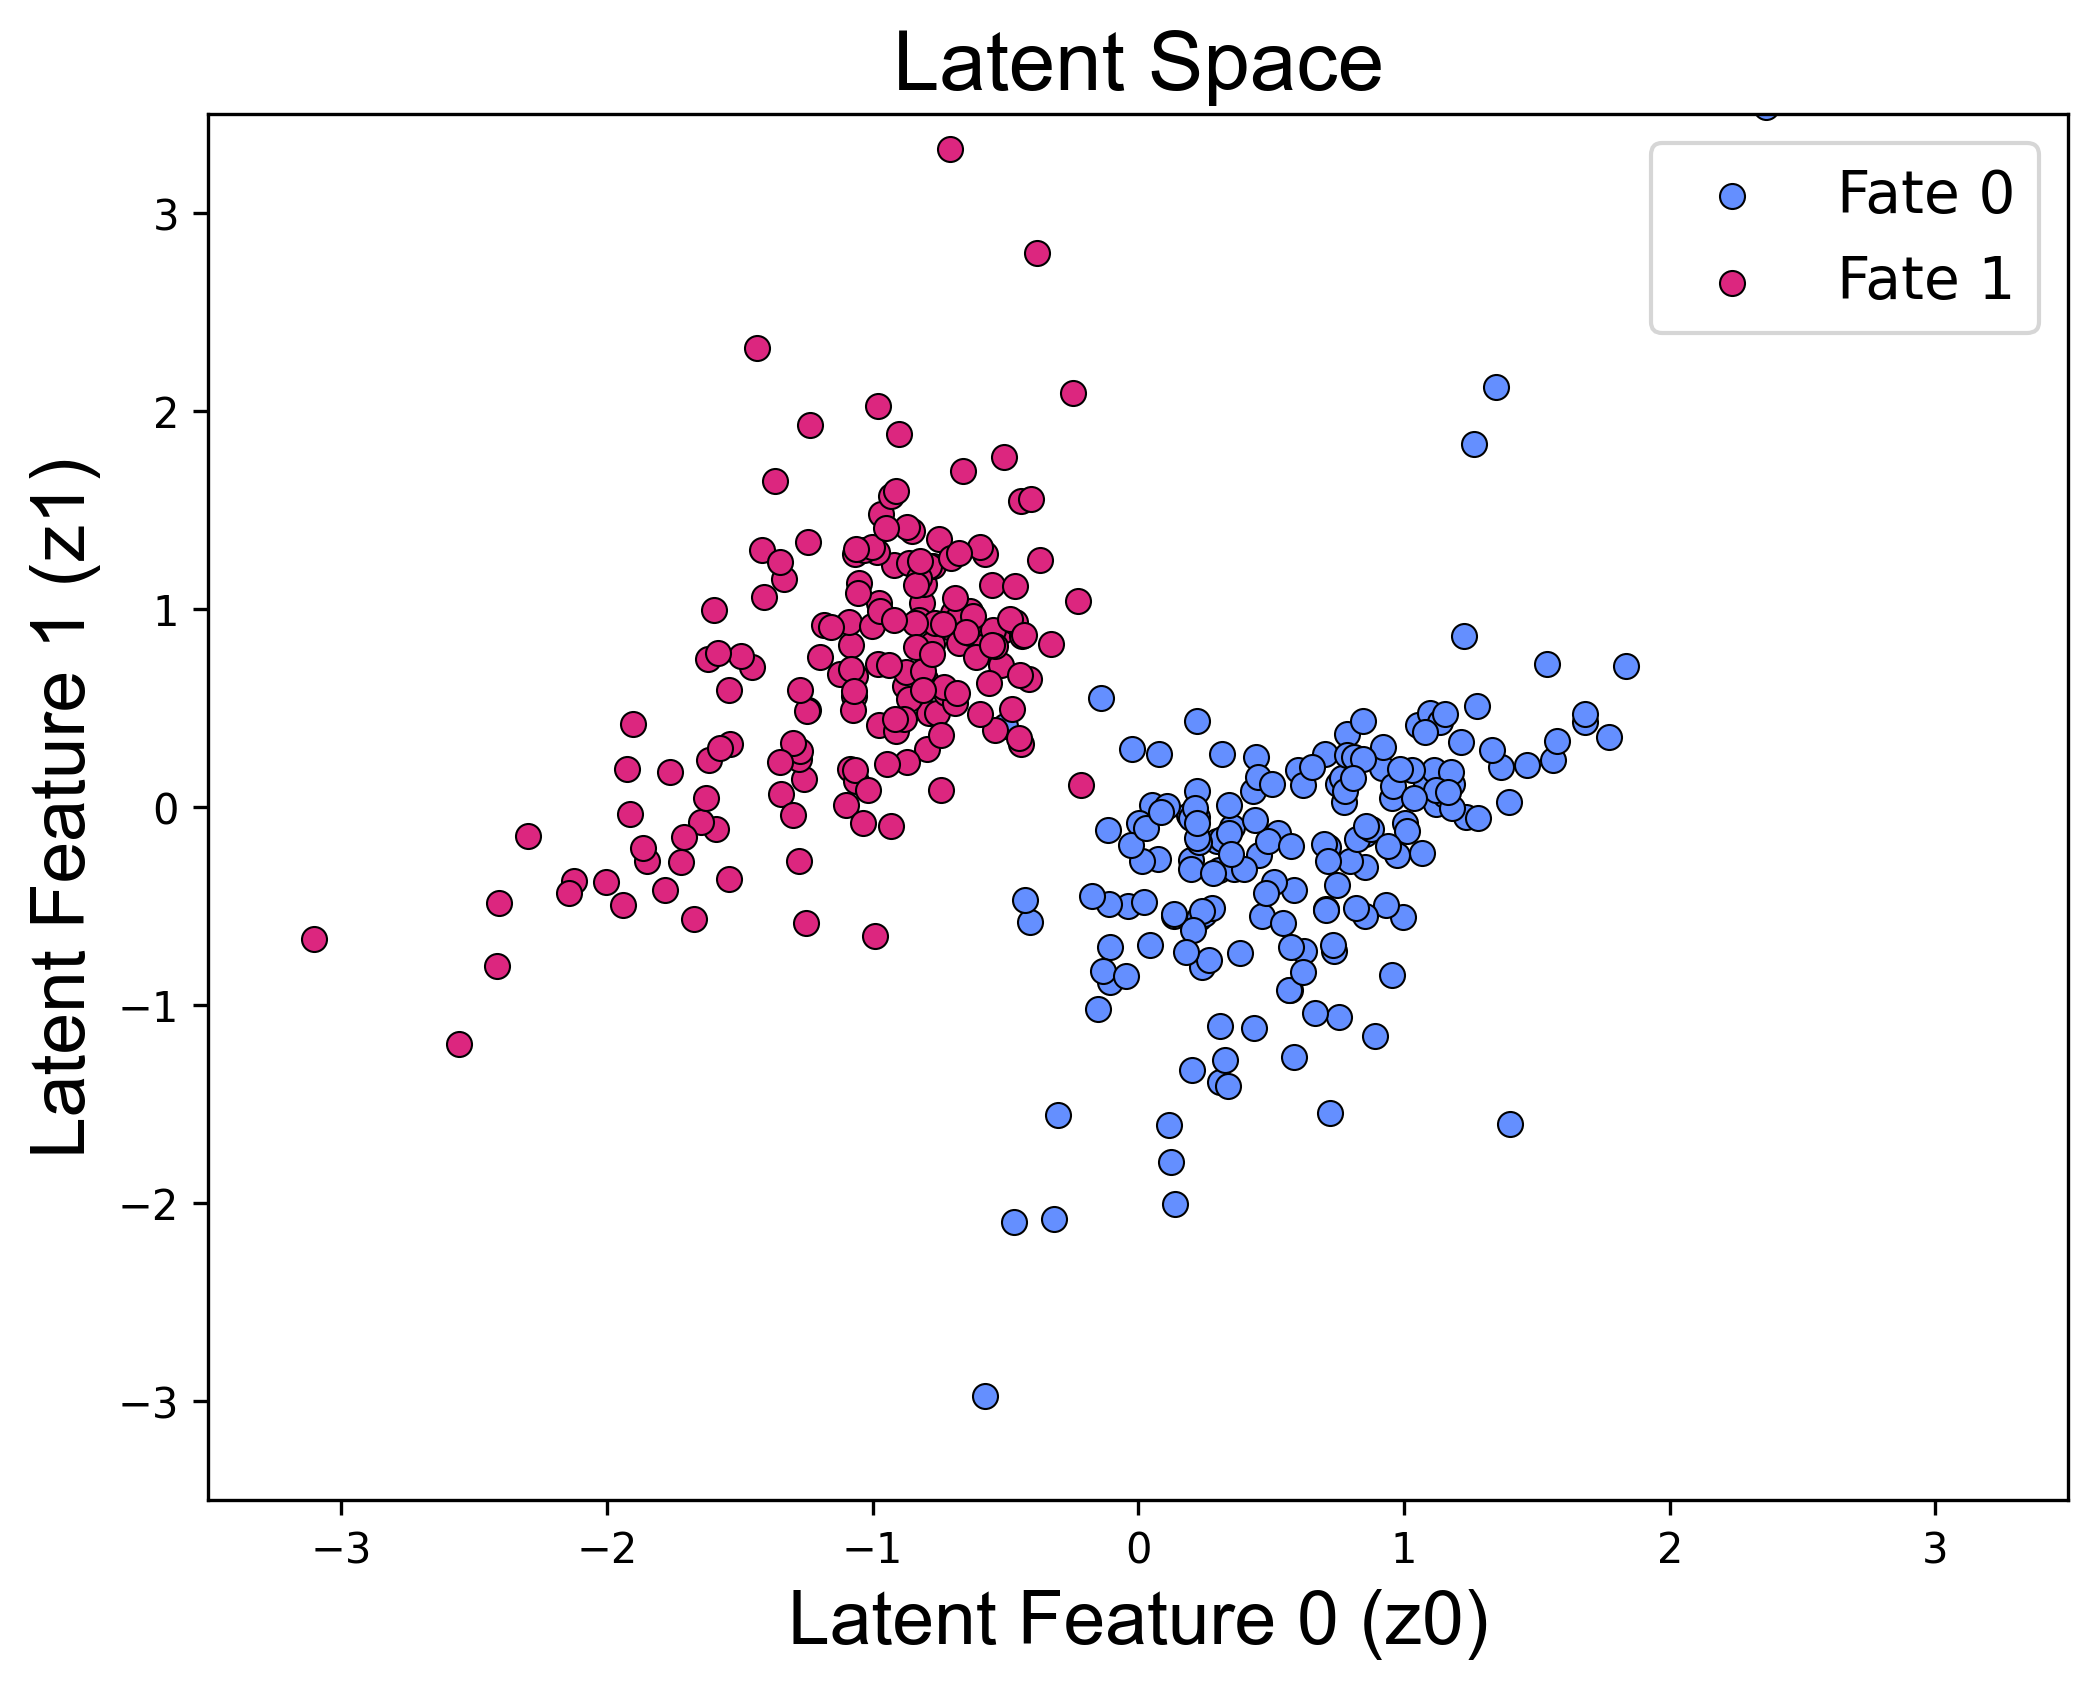

In [11]:
# Predict the latent representations
latent_2d = encoder.predict(x_train)  # Shape (1380, 2)

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_2d[y_train == 0][:, 0], latent_2d[y_train == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_2d[y_train == 1][:, 0], latent_2d[y_train == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Legend and grid
plt.legend(fontsize=14)
#plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("ls_split02_rasterised.eps", dpi=600, bbox_inches="tight")
plt.show()


## 50% labelled data for training

In [12]:
confusion_matrices_split05 = np.zeros((3,2,2))
confusion_matrices_split05[0] = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/split_0.5/confusion_matrices_cellfate.npy")[4]
confusion_matrices_split05[1] = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/seed43_split_0.5/confusion_matrices_cellfate.npy")[4]
confusion_matrices_split05[2] = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/seed44_split_0.5/confusion_matrices_cellfate.npy")[4]

In [13]:
print("Mean",np.mean(confusion_matrices_split05,axis=0))
print("Std",np.std(confusion_matrices_split05,axis=0))

Mean [[0.57957958 0.42042042]
 [0.28571429 0.71428571]]
Std [[0.05990972 0.05990972]
 [0.05050763 0.05050763]]


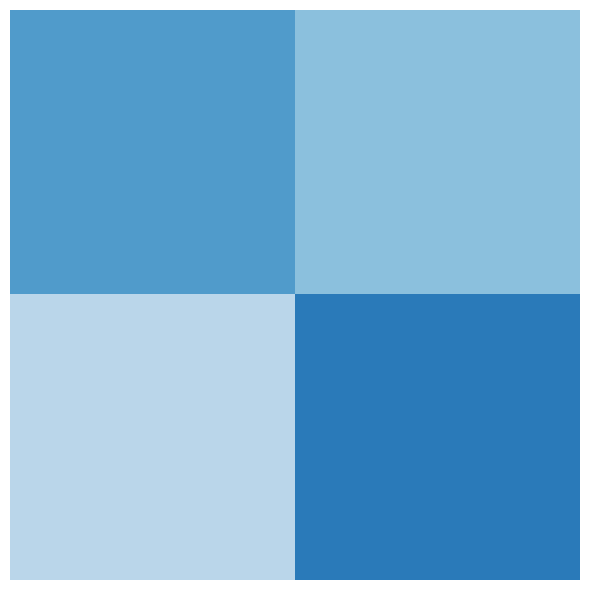

In [14]:
plt.figure(figsize=(8, 6))
plt.imshow(np.mean(confusion_matrices_split05, axis=0), interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.axis('off')
plt.tight_layout()
#plt.savefig("mean_confmatrix_split05.pdf", format="pdf", dpi=300, pad_inches=0)
plt.show()

In [15]:
config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
    'lambda_recon': 5, 
    'lambda_adv': 0.05,
    'lambda_clf': 0.05,
    'lambda_cov': 0.1,
}

size = 0.5
np.random.seed(config['seed'])
less_indexes = np.random.choice(np.arange(len(train_labels)), int(size * len(train_labels)), replace=False)

smaller_x_train_images = train_images[less_indexes]
smaller_y_train = train_labels[less_indexes]
smaller_x_train_tracks = train_tracks[less_indexes]

# Augment image data
smaller_train_images_augmented, smaller_train_labels_augmented = augment_dataset(smaller_x_train_images, smaller_y_train, augmentations)

# Stretch intensities of new images (train and test)
stretched_x_train_smaller, stretched_x_test = stretch_intensities_global(smaller_train_images_augmented, test_images)

# Pick only frame zero
x_train = stretched_x_train_smaller[:,0,:,:]
y_train = smaller_train_labels_augmented
x_test = stretched_x_test[:,0,:,:]
y_test = test_labels

img_shape = (x_train.shape[1], x_train.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

encoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/split_0.5/encoder.weights.h5")
decoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/split_0.5/decoder.weights.h5")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


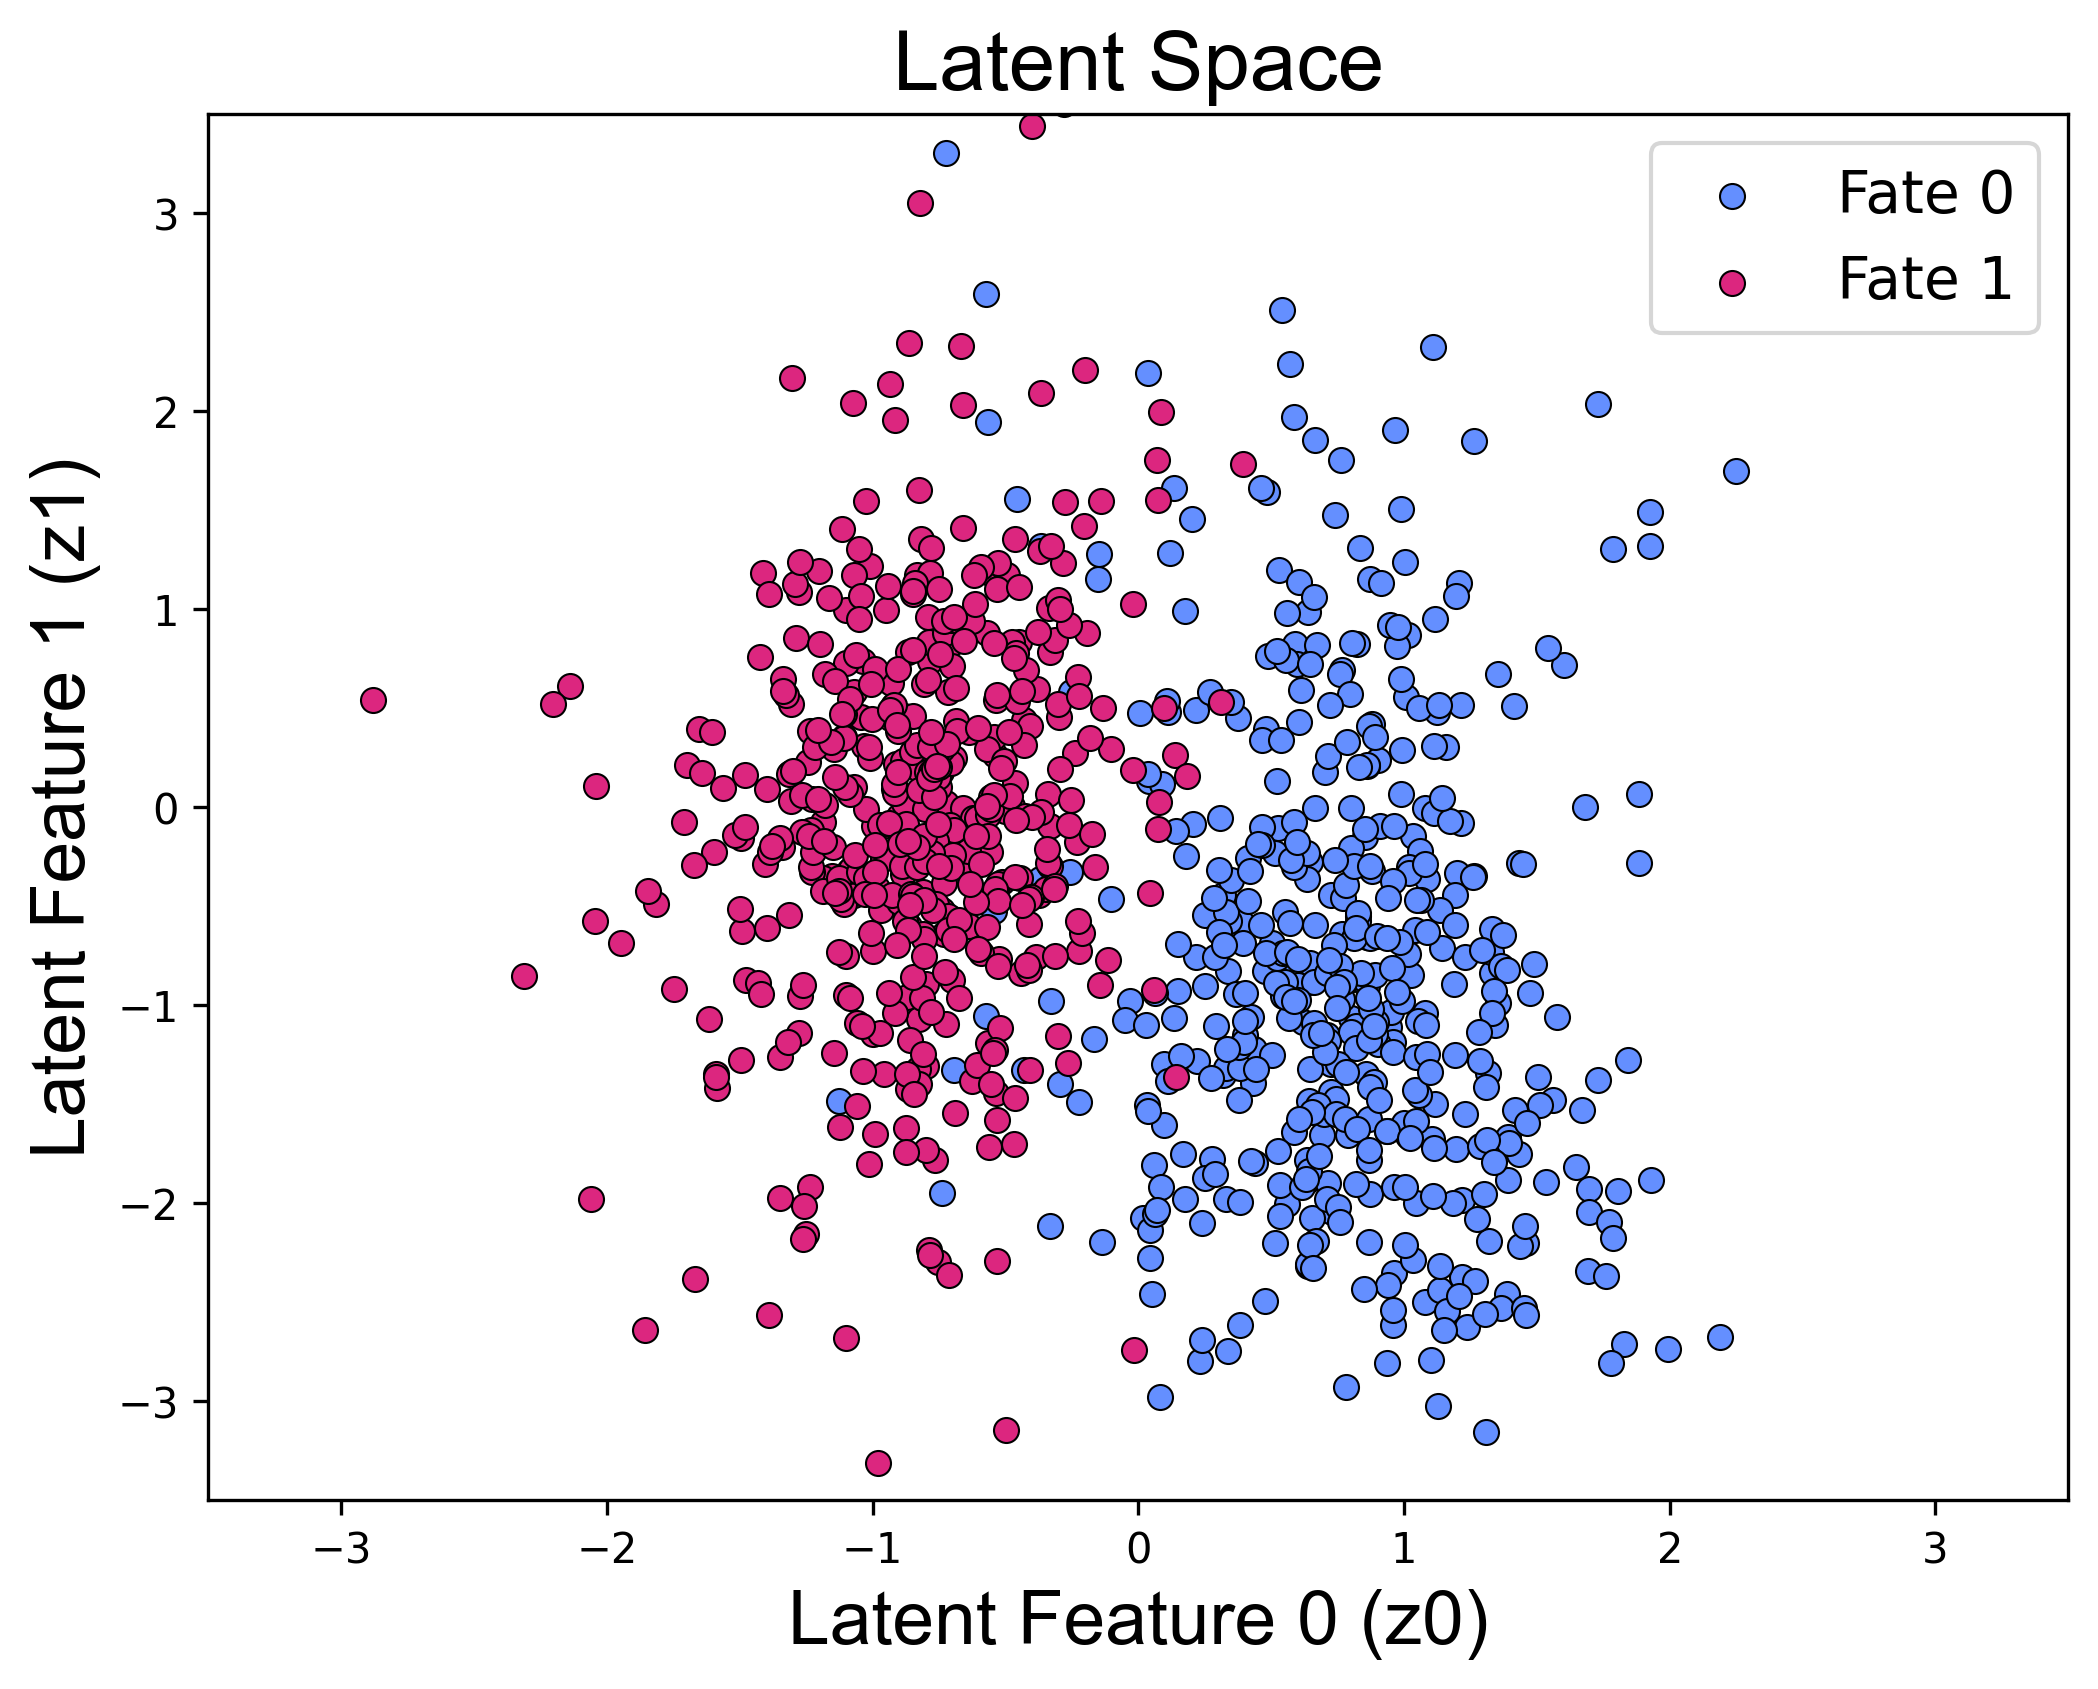

In [16]:
# Predict the latent representations
latent_2d = encoder.predict(x_train)  # Shape (1380, 2)

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately with thin gray edges
plt.scatter(latent_2d[y_train == 0][:, 0], latent_2d[y_train == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  
plt.scatter(latent_2d[y_train == 1][:, 0], latent_2d[y_train == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=1, edgecolors='k', linewidth=0.5, rasterized=True)  

# Set axis limits
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")

# Legend and grid
plt.legend(fontsize=14)
#plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

#plt.savefig("ls_split02_rasterised.eps", dpi=600, bbox_inches="tight")
plt.show()
